# Multiple Clusters Eigenvalue Spectrum on 1st Jan, 2020

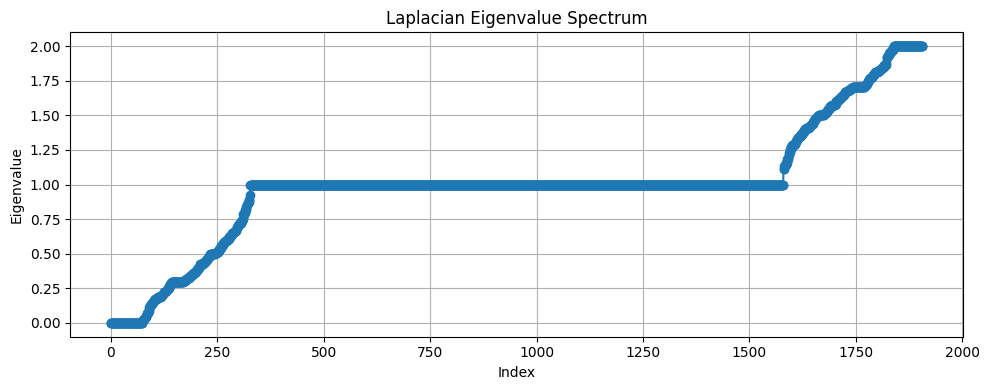


Estimated Number of Clusters: 75

Cluster Sizes: Counter({0: 1683, 6: 22, 1: 16, 10: 11, 7: 7, 11: 7, 17: 6, 4: 5, 8: 5, 2: 5, 3: 4, 9: 4, 16: 4, 24: 3, 22: 3, 23: 3, 21: 3, 37: 3, 12: 3, 5: 3, 71: 2, 69: 2, 44: 2, 20: 2, 27: 2, 56: 2, 53: 2, 47: 2, 13: 2, 62: 2, 43: 2, 49: 2, 70: 2, 45: 2, 39: 2, 64: 2, 34: 2, 67: 2, 28: 2, 46: 2, 36: 2, 41: 2, 38: 2, 40: 2, 35: 2, 18: 2, 54: 2, 42: 2, 50: 2, 61: 2, 26: 2, 55: 2, 48: 2, 14: 2, 15: 2, 63: 2, 31: 2, 68: 2, 52: 2, 51: 2, 66: 2, 65: 2, 33: 2, 29: 2, 60: 2, 59: 2, 58: 2, 30: 2, 19: 2, 57: 2, 32: 2, 25: 2, 74: 1, 72: 1, 73: 1})


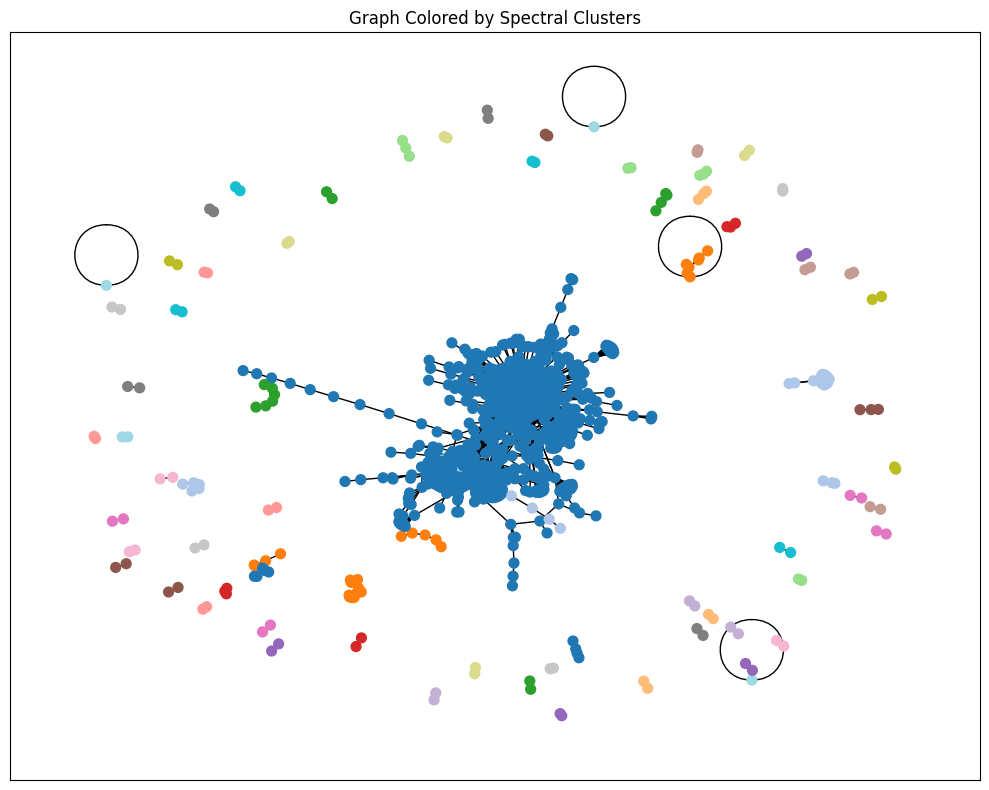


Sample Transactions from Largest Cluster:
                 timestamp  fromLabel  toLabel  tokenAddressLabel  \
0      2020-01-01 00:01:36          3   373817                  3   
1      2020-01-01 00:01:36          3      841                  3   
2      2020-01-01 00:01:36          3   362498               2024   
3      2020-01-01 00:01:45          3      120                  3   
4      2020-01-01 00:01:45          3   373021                  3   
...                    ...        ...      ...                ...   
18899  2020-01-01 23:59:36          3     3258                948   
18900  2020-01-01 23:59:36          3     3258                948   
18901  2020-01-01 23:59:36          3     3258                948   
18902  2020-01-01 23:59:43      76745   313847               2185   
18903  2020-01-01 23:59:43     313847   360779               2185   

       fromIsContract  toIsContract  
0                   0             0  
1                   0             0  
2             

In [5]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from collections import Counter

# === Load CSV ===
df = pd.read_csv("label_jan/2020-01-01.csv")

# === Construct Undirected Graph ===
edges = list(zip(df['fromLabel'], df['toLabel']))
G = nx.Graph()
G.add_edges_from(edges)

# === Create Adjacency Matrix ===
nodes = list(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}
A = nx.to_numpy_array(G, nodelist=nodes)

# === Normalized Laplacian ===
D = np.diag(np.sum(A, axis=1))
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
L = np.identity(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt

# === Eigen Decomposition ===
eigvals, eigvecs = np.linalg.eigh(L)

# === Plot Eigenvalue Spectrum ===
plt.figure(figsize=(10, 4))
plt.plot(np.sort(eigvals), marker='o')
plt.title("Laplacian Eigenvalue Spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Number of clusters = number of zero eigenvalues ===
eps = 1e-5
num_clusters = np.sum(eigvals < eps)
print(f"\nEstimated Number of Clusters: {num_clusters}")

# === Spectral Embedding + Clustering ===
embedding = eigvecs[:, :num_clusters]
Y = normalize(embedding)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(Y)

# === Cluster info ===
cluster_counts = Counter(labels)
print(f"\nCluster Sizes: {cluster_counts}")

# === Visualize Graph with Cluster Coloring ===
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8))
colors = [labels[node_index[n]] for n in G.nodes()]
nx.draw_networkx(G, pos, node_color=colors, cmap=plt.cm.tab20, with_labels=False, node_size=50)
plt.title("Graph Colored by Spectral Clusters")
plt.tight_layout()
plt.show()

# === Get Largest Cluster's Transactions ===
largest_cluster = cluster_counts.most_common(1)[0][0]
largest_nodes = [nodes[i] for i in range(len(nodes)) if labels[i] == largest_cluster]

filtered_df = df[
    df['fromLabel'].isin(largest_nodes) & df['toLabel'].isin(largest_nodes)
]

print("\nSample Transactions from Largest Cluster:")
print(filtered_df)


# Doing for All days of Jan 2020

In [25]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter

# Folder paths
input_folder = "label_jan"
clustering_graph_folder = "clustering_Graph"

# Create output directory if it doesn't exist
os.makedirs(clustering_graph_folder, exist_ok=True)

# Process each CSV file in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_folder, filename)

        # Print status
        print(f"Processing file: {filename}")

        # === Load CSV ===
        df = pd.read_csv(file_path)

        # === Construct Undirected Graph ===
        edges = list(zip(df['fromLabel'], df['toLabel']))
        G = nx.Graph()
        G.add_edges_from(edges)

        # === Create Adjacency Matrix ===
        nodes = list(G.nodes())
        node_index = {node: i for i, node in enumerate(nodes)}
        A = nx.to_numpy_array(G, nodelist=nodes)

        # === Normalized Laplacian ===
        D = np.diag(np.sum(A, axis=1))
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1) + 1e-10))
        L = np.identity(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt

        # === Eigen Decomposition ===
        eigvals, eigvecs = np.linalg.eigh(L)

        # === Plot Eigenvalue Spectrum ===
        plt.figure(figsize=(10, 4))
        plt.plot(np.sort(eigvals), marker='o')
        plt.title(f"Laplacian Eigenvalue Spectrum - {filename}")
        plt.xlabel("Index")
        plt.ylabel("Eigenvalue")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(clustering_graph_folder, f"{filename}_eigenvalue_spectrum.png"))
        plt.close()

        eps = 1e-5
        num_clusters = np.sum(eigvals < eps)
        if num_clusters < 2:
            num_clusters = 2  
        print(f"\nEstimated Number of Clusters for {filename}: {num_clusters}")

        embedding = eigvecs[:, :num_clusters]
        Y = normalize(embedding)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(Y)

        cluster_counts = Counter(labels)
        print(f"\nCluster Sizes for {filename}: {cluster_counts}")

        # Save cluster sizes information to a text file
        with open(os.path.join(clustering_graph_folder, f"{filename}_cluster_sizes.txt"), 'w') as f:
            f.write(f"Cluster Sizes for {filename}:\n")
            for cluster, count in cluster_counts.items():
                f.write(f"Cluster {cluster}: {count} nodes\n")

        # === Visualize Graph with Cluster Coloring ===
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(10, 8))
        colors = [labels[node_index[n]] for n in G.nodes()]
        nx.draw_networkx(G, pos, node_color=colors, cmap=plt.cm.tab20, with_labels=False, node_size=50)
        plt.title(f"Graph Colored by Spectral Clusters - {filename}")
        plt.tight_layout()
        plt.savefig(os.path.join(clustering_graph_folder, f"{filename}_spectral_graph.png"))
        plt.close()


Processing file: 2020-01-01.csv

Estimated Number of Clusters for 2020-01-01.csv: 75

Cluster Sizes for 2020-01-01.csv: Counter({0: 1683, 6: 22, 1: 16, 10: 11, 7: 7, 11: 7, 23: 6, 4: 5, 8: 5, 2: 5, 3: 4, 9: 4, 16: 4, 34: 3, 22: 3, 24: 3, 25: 3, 21: 3, 12: 3, 5: 3, 13: 2, 59: 2, 66: 2, 27: 2, 44: 2, 20: 2, 30: 2, 56: 2, 51: 2, 53: 2, 37: 2, 54: 2, 40: 2, 43: 2, 41: 2, 49: 2, 64: 2, 67: 2, 65: 2, 28: 2, 36: 2, 46: 2, 58: 2, 38: 2, 63: 2, 18: 2, 35: 2, 42: 2, 62: 2, 48: 2, 26: 2, 70: 2, 68: 2, 14: 2, 15: 2, 17: 2, 52: 2, 61: 2, 31: 2, 55: 2, 50: 2, 71: 2, 45: 2, 47: 2, 29: 2, 33: 2, 39: 2, 69: 2, 60: 2, 19: 2, 57: 2, 32: 2, 74: 1, 72: 1, 73: 1})
Processing file: 2020-01-02.csv

Estimated Number of Clusters for 2020-01-02.csv: 88

Cluster Sizes for 2020-01-02.csv: Counter({0: 2076, 1: 22, 5: 9, 7: 9, 6: 9, 3: 9, 2: 7, 4: 7, 15: 6, 25: 6, 10: 5, 8: 5, 12: 5, 17: 5, 11: 4, 28: 4, 13: 4, 47: 3, 9: 3, 36: 3, 29: 3, 20: 3, 39: 3, 19: 3, 43: 3, 30: 3, 14: 3, 32: 3, 64: 2, 52: 2, 46: 2, 82: 2, 45

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter

# Folder paths
input_folder = "label_jan"
spectral_output_folder = "multiple_CLuster_jan"
filtered_output_folder = "max_cluster_Jan"

# Create output directories if they don't exist
os.makedirs(spectral_output_folder, exist_ok=True)
os.makedirs(filtered_output_folder, exist_ok=True)

# Process each CSV file in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_folder, filename)
        
        # Print status
        print(f"Processing file: {filename}")

        # === Load CSV ===
        df = pd.read_csv(file_path)

        # === Construct Undirected Graph ===
        edges = list(zip(df['fromLabel'], df['toLabel']))
        G = nx.Graph()
        G.add_edges_from(edges)

        # === Create Adjacency Matrix ===
        nodes = list(G.nodes())
        node_index = {node: i for i, node in enumerate(nodes)}
        A = nx.to_numpy_array(G, nodelist=nodes)

        # === Normalized Laplacian ===
        D = np.diag(np.sum(A, axis=1))
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1) + 1e-10))
        L = np.identity(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt

        # === Eigen Decomposition ===
        eigvals, eigvecs = np.linalg.eigh(L)

        # === Plot Eigenvalue Spectrum ===
        plt.figure(figsize=(10, 4))
        plt.plot(np.sort(eigvals), marker='o')
        plt.title(f"Laplacian Eigenvalue Spectrum - {filename}")
        plt.xlabel("Index")
        plt.ylabel("Eigenvalue")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(spectral_output_folder, f"{filename}_eigenvalue_spectrum.png"))
        plt.close()

        eps = 1e-5
        num_clusters = np.sum(eigvals < eps)
        if num_clusters < 2:
            num_clusters = 2  
        print(f"\nEstimated Number of Clusters for {filename}: {num_clusters}")

        embedding = eigvecs[:, :num_clusters]
        Y = normalize(embedding)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(Y)

        if num_clusters > 1 and len(set(labels)) > 1:
            try:
                sil_score = silhouette_score(Y, labels)
                print(f"Silhouette Score for {filename}: {sil_score:.4f}")
            except Exception as e:
                print(f"Could not calculate silhouette score for {filename}: {e}")
        else:
            print(f"Silhouette Score not applicable for {filename} (only one cluster)")

        cluster_counts = Counter(labels)
        print(f"\nCluster Sizes for {filename}: {cluster_counts}")

        # === Visualize Graph with Cluster Coloring ===
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(10, 8))
        colors = [labels[node_index[n]] for n in G.nodes()]
        nx.draw_networkx(G, pos, node_color=colors, cmap=plt.cm.tab20, with_labels=False, node_size=50)
        plt.title(f"Graph Colored by Spectral Clusters - {filename}")
        plt.tight_layout()
        plt.savefig(os.path.join(spectral_output_folder, f"{filename}_spectral_graph.png"))
        plt.close()

        # === Get Largest Cluster's Transactions ===
        largest_cluster = cluster_counts.most_common(1)[0][0]
        largest_nodes = [nodes[i] for i in range(len(nodes)) if labels[i] == largest_cluster]

        filtered_df = df[
            df['fromLabel'].isin(largest_nodes) & df['toLabel'].isin(largest_nodes)
        ]

        # Save the filtered transactions of the largest cluster
        filtered_df.to_csv(os.path.join(filtered_output_folder, f"{filename}_filtered_transactions.csv"), index=False)

        print(f"Saved filtered transactions for {filename} in {filtered_output_folder}")
        print("=" * 60)


Processing file: 2020-01-01.csv

Estimated Number of Clusters for 2020-01-01.csv: 75
Silhouette Score for 2020-01-01.csv: 0.9984

Cluster Sizes for 2020-01-01.csv: Counter({0: 1683, 6: 22, 1: 16, 10: 11, 7: 7, 11: 7, 23: 6, 4: 5, 8: 5, 2: 5, 3: 4, 9: 4, 16: 4, 34: 3, 22: 3, 24: 3, 25: 3, 21: 3, 12: 3, 5: 3, 13: 2, 59: 2, 66: 2, 27: 2, 44: 2, 20: 2, 30: 2, 56: 2, 51: 2, 53: 2, 37: 2, 54: 2, 40: 2, 43: 2, 41: 2, 49: 2, 64: 2, 67: 2, 65: 2, 28: 2, 36: 2, 46: 2, 58: 2, 38: 2, 63: 2, 18: 2, 35: 2, 42: 2, 62: 2, 48: 2, 26: 2, 70: 2, 68: 2, 14: 2, 15: 2, 17: 2, 52: 2, 61: 2, 31: 2, 55: 2, 50: 2, 71: 2, 45: 2, 47: 2, 29: 2, 33: 2, 39: 2, 69: 2, 60: 2, 19: 2, 57: 2, 32: 2, 74: 1, 72: 1, 73: 1})
Saved filtered transactions for 2020-01-01.csv in max_cluster_Jan
Processing file: 2020-01-02.csv

Estimated Number of Clusters for 2020-01-02.csv: 88
Silhouette Score for 2020-01-02.csv: 0.9991

Cluster Sizes for 2020-01-02.csv: Counter({0: 2076, 1: 22, 5: 9, 7: 9, 6: 9, 3: 9, 2: 7, 4: 7, 15: 6, 25: 6, 

# Calculating Clustrering Metrices

In [32]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, fowlkes_mallows_score
from collections import Counter

# Folder paths
input_folder = "label_jan"
metrics_output_file = "clustering_metrics.csv"

# Prepare metrics data
metrics_data = []

# Process each CSV file in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_folder, filename)
        
        # Print status
        print(f"Processing file: {filename}")

        # === Load CSV ===
        df = pd.read_csv(file_path)

        # === Construct Undirected Graph ===
        edges = list(zip(df['fromLabel'], df['toLabel']))
        G = nx.Graph()
        G.add_edges_from(edges)

        # === Create Adjacency Matrix ===
        nodes = list(G.nodes())
        node_index = {node: i for i, node in enumerate(nodes)}
        A = nx.to_numpy_array(G, nodelist=nodes)

        # === Normalized Laplacian ===
        D = np.diag(np.sum(A, axis=1))
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1) + 1e-10))
        L = np.identity(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt

        # === Eigen Decomposition ===
        eigvals, eigvecs = np.linalg.eigh(L)

        eps = 1e-5
        num_clusters = np.sum(eigvals < eps)
        if num_clusters < 2:
            num_clusters = 2  
        print(f"\nEstimated Number of Clusters for {filename}: {num_clusters}")

        embedding = eigvecs[:, :num_clusters]
        Y = normalize(embedding)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(Y)

        if num_clusters > 1 and len(set(labels)) > 1:
            try:
                # Calculate silhouette score
                sil_score = silhouette_score(Y, labels)

                # Calculate Davies-Bouldin score
                db_score = davies_bouldin_score(Y, labels)

                # Calculate Calinski-Harabasz score
                ch_score = calinski_harabasz_score(Y, labels)

                # Fowlkes-Mallows Index (FMI) - Using the labels themselves
                fmi_score = fowlkes_mallows_score(labels, labels)

                # Save the metrics
                metrics_data.append({
                    'File': filename,
                    'Silhouette Score': sil_score,
                    'Davies-Bouldin Index': db_score,
                    'Calinski-Harabasz Index': ch_score,
                    'Fowlkes-Mallows Index': fmi_score
                })

                print(f"Silhouette Score: {sil_score:.4f}")
                print(f"Davies-Bouldin Index: {db_score:.4f}")
                print(f"Calinski-Harabasz Index: {ch_score:.4f}")
                print(f"Fowlkes-Mallows Index: {fmi_score:.4f}")

            except Exception as e:
                print(f"Error calculating metrics for {filename}: {e}")
        else:
            print(f"Silhouette Score not applicable for {filename} (only one cluster)")

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv(metrics_output_file, index=False)
print(f"Saved metrics to {metrics_output_file}")


Processing file: 2020-01-01.csv

Estimated Number of Clusters for 2020-01-01.csv: 75
Silhouette Score: 0.9984
Davies-Bouldin Index: 0.0000
Calinski-Harabasz Index: 889420504811813385650831360.0000
Fowlkes-Mallows Index: 1.0000
Processing file: 2020-01-02.csv

Estimated Number of Clusters for 2020-01-02.csv: 88
Silhouette Score: 0.9991
Davies-Bouldin Index: 0.0000
Calinski-Harabasz Index: 2437383388049476445219586048.0000
Fowlkes-Mallows Index: 1.0000
Processing file: 2020-01-03.csv

Estimated Number of Clusters for 2020-01-03.csv: 78
Silhouette Score: 1.0000
Davies-Bouldin Index: 0.0000
Calinski-Harabasz Index: 236668138887099581011591168.0000
Fowlkes-Mallows Index: 1.0000
Processing file: 2020-01-04.csv

Estimated Number of Clusters for 2020-01-04.csv: 74
Silhouette Score: 1.0000
Davies-Bouldin Index: 0.0000
Calinski-Harabasz Index: 3015058401801976768509247488.0000
Fowlkes-Mallows Index: 1.0000
Processing file: 2020-01-05.csv

Estimated Number of Clusters for 2020-01-05.csv: 78
Silho

# Hypergraph Clustering


Number of zero eigenvalues (clusters): 17


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\2711230960.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


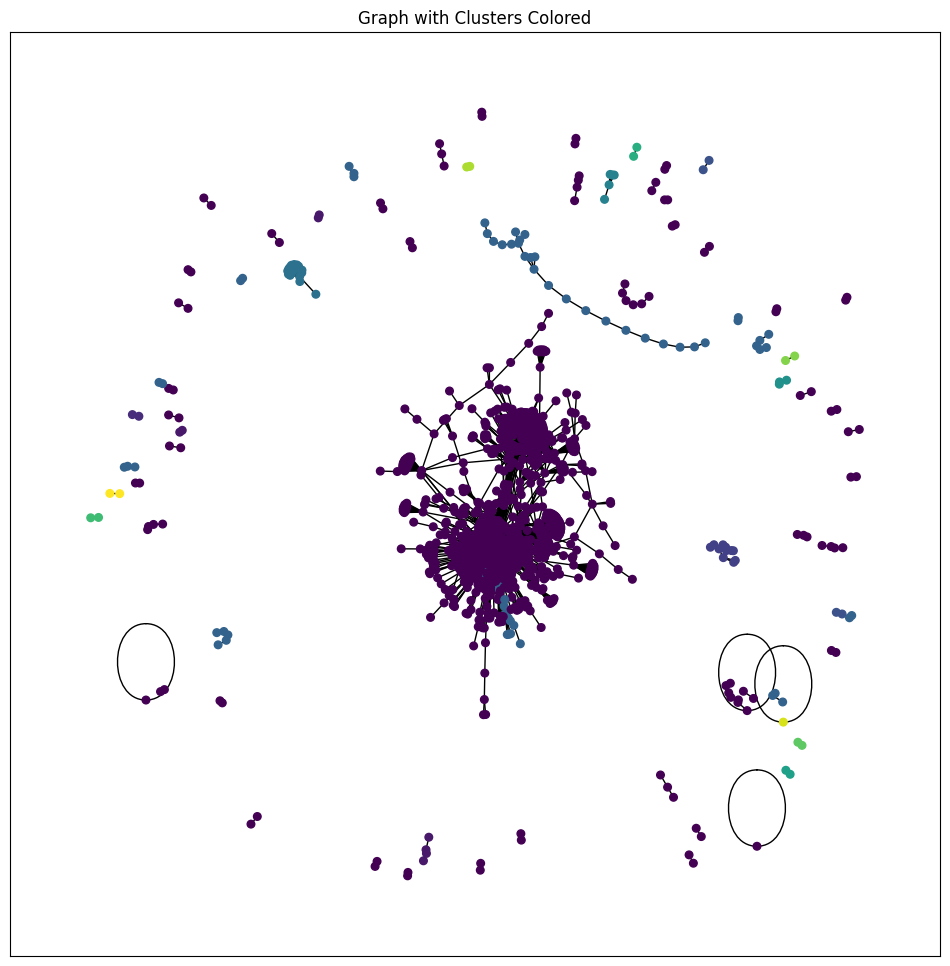

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from scipy.linalg import eigh

# Step 1: Load CSV
file_path = 'label_jan/2020-01-01.csv'
df = pd.read_csv(file_path)
df = df[['fromLabel', 'toLabel', 'tokenAddressLabel']].dropna().drop_duplicates()

# Step 2: Build vertex and hyperedge sets
vertices = list(set(df['fromLabel']) | set(df['toLabel']))
edges = df['tokenAddressLabel'].unique().tolist()

v_idx = {v: i for i, v in enumerate(vertices)}
e_idx = {e: i for i, e in enumerate(edges)}

n = len(vertices)
m = len(edges)

# Step 3: Build incidence matrix H (n x m)
H = np.zeros((n, m))
for _, row in df.iterrows():
    i = v_idx[row['fromLabel']]
    j = v_idx[row['toLabel']]
    e = e_idx[row['tokenAddressLabel']]
    H[i][e] = 1
    H[j][e] = 1

# Step 4: Compute Dv, De, W
De_vals = np.sum(H, axis=0)  # Degree of hyperedges
Dv_vals = np.sum(H, axis=1)  # Degree of vertices
W_vals = np.ones(m)          # Weight of each hyperedge = 1

Dv_inv_sqrt = np.diag(1.0 / np.sqrt(Dv_vals + 1e-10))  # Add epsilon to avoid divide by zero
De_inv = np.diag(1.0 / (De_vals + 1e-10))              # Same here
W = np.diag(W_vals)

# Step 5: Compute normalized Laplacian
L = np.identity(n) - Dv_inv_sqrt @ H @ W @ De_inv @ H.T @ Dv_inv_sqrt

# Step 6: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(L)
eigenvalues = np.round(eigenvalues, 6)

# Step 7: Count number of zero eigenvalues => number of clusters
zero_eigen_count = np.sum(np.isclose(eigenvalues, 0.0, atol=1e-6))
print(f'Number of zero eigenvalues (clusters): {zero_eigen_count}')

# Step 8: Spectral Clustering using KMeans
# Take eigenvectors corresponding to the smallest non-zero eigenvalues
# Typically, we take the first `zero_eigen_count` eigenvectors
eigenvectors_for_clustering = eigenvectors[:, 1:zero_eigen_count+1]

# Step 9: Apply KMeans clustering
kmeans = KMeans(n_clusters=zero_eigen_count, random_state=42)
kmeans.fit(eigenvectors_for_clustering)

# Step 10: Assign clusters to each vertex
labels = kmeans.labels_

# Step 11: Create a graph using NetworkX
G = nx.Graph()

# Add nodes (vertices)
for i, vertex in enumerate(vertices):
    G.add_node(vertex, cluster=labels[i])

# Add edges based on the hypergraph (edges between vertices in the same hyperedge)
for _, row in df.iterrows():
    from_vertex = row['fromLabel']
    to_vertex = row['toLabel']
    G.add_edge(from_vertex, to_vertex)

# Step 12: Draw the graph with nodes colored based on their cluster
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # For consistent layout

# Color the nodes according to their cluster assignment
node_colors = [G.nodes[node]['cluster'] for node in G.nodes]
nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)

plt.title("Graph with Clusters Colored")
plt.show()


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from scipy.linalg import eigh

# Function to process each file and save the results
def process_file(file_path, save_dir):
    print(f"Processing file: {file_path}")  # Print the file being processed
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    df = df[['fromLabel', 'toLabel', 'tokenAddressLabel']].dropna().drop_duplicates()

    # Build vertex and hyperedge sets
    vertices = list(set(df['fromLabel']) | set(df['toLabel']))
    edges = df['tokenAddressLabel'].unique().tolist()

    v_idx = {v: i for i, v in enumerate(vertices)}
    e_idx = {e: i for i, e in enumerate(edges)}

    n = len(vertices)
    m = len(edges)

    # Build incidence matrix H (n x m)
    H = np.zeros((n, m))
    for _, row in df.iterrows():
        i = v_idx[row['fromLabel']]
        j = v_idx[row['toLabel']]
        e = e_idx[row['tokenAddressLabel']]
        H[i][e] = 1
        H[j][e] = 1

    # Compute Dv, De, W
    De_vals = np.sum(H, axis=0)  # Degree of hyperedges
    Dv_vals = np.sum(H, axis=1)  # Degree of vertices
    W_vals = np.ones(m)          # Weight of each hyperedge = 1

    Dv_inv_sqrt = np.diag(1.0 / np.sqrt(Dv_vals + 1e-10))  # Add epsilon to avoid divide by zero
    De_inv = np.diag(1.0 / (De_vals + 1e-10))              # Same here
    W = np.diag(W_vals)

    # Compute normalized Laplacian
    L = np.identity(n) - Dv_inv_sqrt @ H @ W @ De_inv @ H.T @ Dv_inv_sqrt

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(L)
    eigenvalues = np.round(eigenvalues, 6)

    # Count number of zero eigenvalues => number of clusters
    zero_eigen_count = np.sum(np.isclose(eigenvalues, 0.0, atol=1e-6))
    print(f'File: {file_path} - Number of zero eigenvalues (clusters): {zero_eigen_count}')

    # Save eigenvalue spectrum plot
    eigenvalue_plot_path = os.path.join(save_dir, f'{os.path.basename(file_path)}_eigenvalues.png')
    plt.figure(figsize=(8, 6))
    plt.plot(np.sort(eigenvalues))
    plt.title(f"Eigenvalue Spectrum for {os.path.basename(file_path)}")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.grid(True)
    plt.savefig(eigenvalue_plot_path)
    plt.close()

    # Spectral Clustering using KMeans
    eigenvectors_for_clustering = eigenvectors[:, 1:zero_eigen_count+1]

    kmeans = KMeans(n_clusters=zero_eigen_count, random_state=42)
    kmeans.fit(eigenvectors_for_clustering)

    # Create a graph using NetworkX
    G = nx.Graph()

    # Add nodes (vertices)
    for i, vertex in enumerate(vertices):
        G.add_node(vertex, cluster=kmeans.labels_[i])

    # Add edges based on the hypergraph (edges between vertices in the same hyperedge)
    for _, row in df.iterrows():
        from_vertex = row['fromLabel']
        to_vertex = row['toLabel']
        G.add_edge(from_vertex, to_vertex)

    # Save the graph with clusters colored
    graph_plot_path = os.path.join(save_dir, f'{os.path.basename(file_path)}_clusters.png')
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout

    # Color the nodes according to their cluster assignment
    node_colors = [G.nodes[node]['cluster'] for node in G.nodes]
    nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)

    plt.title(f"Graph with Clusters for {os.path.basename(file_path)}")
    plt.savefig(graph_plot_path)
    plt.close()

    # Save the number of clusters and the number of nodes in each cluster to a text file
    cluster_info_path = os.path.join(save_dir, f'{os.path.basename(file_path)}_cluster_info.txt')
    with open(cluster_info_path, 'w') as f:
        f.write(f"File: {file_path}\n")
        f.write(f"Number of clusters: {zero_eigen_count}\n")
        f.write("\nCluster distribution:\n")
        
        # Count the number of nodes in each cluster
        cluster_counts = np.bincount(kmeans.labels_)
        for i, count in enumerate(cluster_counts):
            f.write(f"Cluster {i}: {count} nodes\n")

# Main function to process all files in the folder
def process_all_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each CSV file in the folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            process_file(file_path, output_folder)

# Folder paths
input_folder = 'label_jan'  # Input folder with CSV files
output_folder = 'clustering_HG'  # Output folder to save results

# Process all files
process_all_files(input_folder, output_folder)


Processing file: label_jan\2020-01-01.csv
File: label_jan\2020-01-01.csv - Number of zero eigenvalues (clusters): 17


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-02.csv
File: label_jan\2020-01-02.csv - Number of zero eigenvalues (clusters): 10


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-03.csv
File: label_jan\2020-01-03.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-04.csv
File: label_jan\2020-01-04.csv - Number of zero eigenvalues (clusters): 18


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-05.csv
File: label_jan\2020-01-05.csv - Number of zero eigenvalues (clusters): 20


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-06.csv
File: label_jan\2020-01-06.csv - Number of zero eigenvalues (clusters): 19


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-07.csv
File: label_jan\2020-01-07.csv - Number of zero eigenvalues (clusters): 23


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-08.csv
File: label_jan\2020-01-08.csv - Number of zero eigenvalues (clusters): 13


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-09.csv
File: label_jan\2020-01-09.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-10.csv
File: label_jan\2020-01-10.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-11.csv
File: label_jan\2020-01-11.csv - Number of zero eigenvalues (clusters): 16


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-12.csv
File: label_jan\2020-01-12.csv - Number of zero eigenvalues (clusters): 21


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-13.csv
File: label_jan\2020-01-13.csv - Number of zero eigenvalues (clusters): 17


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-14.csv
File: label_jan\2020-01-14.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-15.csv
File: label_jan\2020-01-15.csv - Number of zero eigenvalues (clusters): 21


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-16.csv
File: label_jan\2020-01-16.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-17.csv
File: label_jan\2020-01-17.csv - Number of zero eigenvalues (clusters): 20


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-18.csv
File: label_jan\2020-01-18.csv - Number of zero eigenvalues (clusters): 18


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-19.csv
File: label_jan\2020-01-19.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-20.csv
File: label_jan\2020-01-20.csv - Number of zero eigenvalues (clusters): 7


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-21.csv
File: label_jan\2020-01-21.csv - Number of zero eigenvalues (clusters): 10


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-22.csv
File: label_jan\2020-01-22.csv - Number of zero eigenvalues (clusters): 14


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-23.csv
File: label_jan\2020-01-23.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-24.csv
File: label_jan\2020-01-24.csv - Number of zero eigenvalues (clusters): 14


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-25.csv
File: label_jan\2020-01-25.csv - Number of zero eigenvalues (clusters): 23


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-26.csv
File: label_jan\2020-01-26.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-27.csv
File: label_jan\2020-01-27.csv - Number of zero eigenvalues (clusters): 21


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-28.csv
File: label_jan\2020-01-28.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-29.csv
File: label_jan\2020-01-29.csv - Number of zero eigenvalues (clusters): 20


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-30.csv
File: label_jan\2020-01-30.csv - Number of zero eigenvalues (clusters): 24


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


Processing file: label_jan\2020-01-31.csv
File: label_jan\2020-01-31.csv - Number of zero eigenvalues (clusters): 15


C:\Users\anand\AppData\Local\Temp\ipykernel_7900\5955691.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx(G, pos, node_color=node_colors, cmap=plt.cm.get_cmap('viridis', zero_eigen_count), with_labels=False, node_size=30)


In [33]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, fowlkes_mallows_score
from scipy.linalg import eigh

# Function to process each file and calculate clustering scores
def process_file(file_path, save_dir, results):
    print(f"Processing file: {file_path}")  # Print the file being processed
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    df = df[['fromLabel', 'toLabel', 'tokenAddressLabel']].dropna().drop_duplicates()

    # Build vertex and hyperedge sets
    vertices = list(set(df['fromLabel']) | set(df['toLabel']))
    edges = df['tokenAddressLabel'].unique().tolist()

    v_idx = {v: i for i, v in enumerate(vertices)}
    e_idx = {e: i for i, e in enumerate(edges)}

    n = len(vertices)
    m = len(edges)

    # Build incidence matrix H (n x m)
    H = np.zeros((n, m))
    for _, row in df.iterrows():
        i = v_idx[row['fromLabel']]
        j = v_idx[row['toLabel']]
        e = e_idx[row['tokenAddressLabel']]
        H[i][e] = 1
        H[j][e] = 1

    # Compute Dv, De, W
    De_vals = np.sum(H, axis=0)  # Degree of hyperedges
    Dv_vals = np.sum(H, axis=1)  # Degree of vertices
    W_vals = np.ones(m)          # Weight of each hyperedge = 1

    Dv_inv_sqrt = np.diag(1.0 / np.sqrt(Dv_vals + 1e-10))  # Add epsilon to avoid divide by zero
    De_inv = np.diag(1.0 / (De_vals + 1e-10))              # Same here
    W = np.diag(W_vals)

    # Compute normalized Laplacian
    L = np.identity(n) - Dv_inv_sqrt @ H @ W @ De_inv @ H.T @ Dv_inv_sqrt

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(L)
    eigenvalues = np.round(eigenvalues, 6)

    # Count number of zero eigenvalues => number of clusters
    zero_eigen_count = np.sum(np.isclose(eigenvalues, 0.0, atol=1e-6))
    print(f'File: {file_path} - Number of zero eigenvalues (clusters): {zero_eigen_count}')

    # Spectral Clustering using KMeans
    eigenvectors_for_clustering = eigenvectors[:, 1:zero_eigen_count+1]

    kmeans = KMeans(n_clusters=zero_eigen_count, random_state=42)
    kmeans.fit(eigenvectors_for_clustering)

    # Calculate clustering metrics
    labels = kmeans.labels_
    try:
        silhouette = silhouette_score(eigenvectors_for_clustering, labels)
    except ValueError:
        silhouette = None

    try:
        davies_bouldin = davies_bouldin_score(eigenvectors_for_clustering, labels)
    except ValueError:
        davies_bouldin = None

    try:
        calinski_harabasz = calinski_harabasz_score(eigenvectors_for_clustering, labels)
    except ValueError:
        calinski_harabasz = None

    try:
        fowlkes_mallows = fowlkes_mallows_score(eigenvectors_for_clustering, labels)
    except ValueError:
        fowlkes_mallows = None

    # Save the results in the dictionary
    results.append({
        'file': os.path.basename(file_path),
        'silhouette_score': silhouette,
        'davies_bouldin_index': davies_bouldin,
        'calinski_harabasz_index': calinski_harabasz,
        'fowlkes_mallows_index': fowlkes_mallows
    })

# Main function to process all files in the folder
def process_all_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    results = []  # List to store the results

    # Iterate through each CSV file in the folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            process_file(file_path, output_folder, results)

    # Convert results to a DataFrame and save as CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(output_folder, 'clustering_metrics.csv'), index=False)
    print(f"Clustering metrics saved to {os.path.join(output_folder, 'clustering_metrics.csv')}")

# Folder paths
input_folder = 'label_jan'  # Input folder with CSV files
output_folder = 'clustering_HG_scores'  # Output folder to save results

# Process all files
process_all_files(input_folder, output_folder)


Processing file: label_jan\2020-01-01.csv
File: label_jan\2020-01-01.csv - Number of zero eigenvalues (clusters): 17
Processing file: label_jan\2020-01-02.csv
File: label_jan\2020-01-02.csv - Number of zero eigenvalues (clusters): 10
Processing file: label_jan\2020-01-03.csv
File: label_jan\2020-01-03.csv - Number of zero eigenvalues (clusters): 15
Processing file: label_jan\2020-01-04.csv
File: label_jan\2020-01-04.csv - Number of zero eigenvalues (clusters): 18
Processing file: label_jan\2020-01-05.csv
File: label_jan\2020-01-05.csv - Number of zero eigenvalues (clusters): 20
Processing file: label_jan\2020-01-06.csv
File: label_jan\2020-01-06.csv - Number of zero eigenvalues (clusters): 19
Processing file: label_jan\2020-01-07.csv
File: label_jan\2020-01-07.csv - Number of zero eigenvalues (clusters): 23
Processing file: label_jan\2020-01-08.csv
File: label_jan\2020-01-08.csv - Number of zero eigenvalues (clusters): 13
Processing file: label_jan\2020-01-09.csv
File: label_jan\2020-0

# Comparison of Both Clustering Methods ( On Hypergraphs and Graphs)

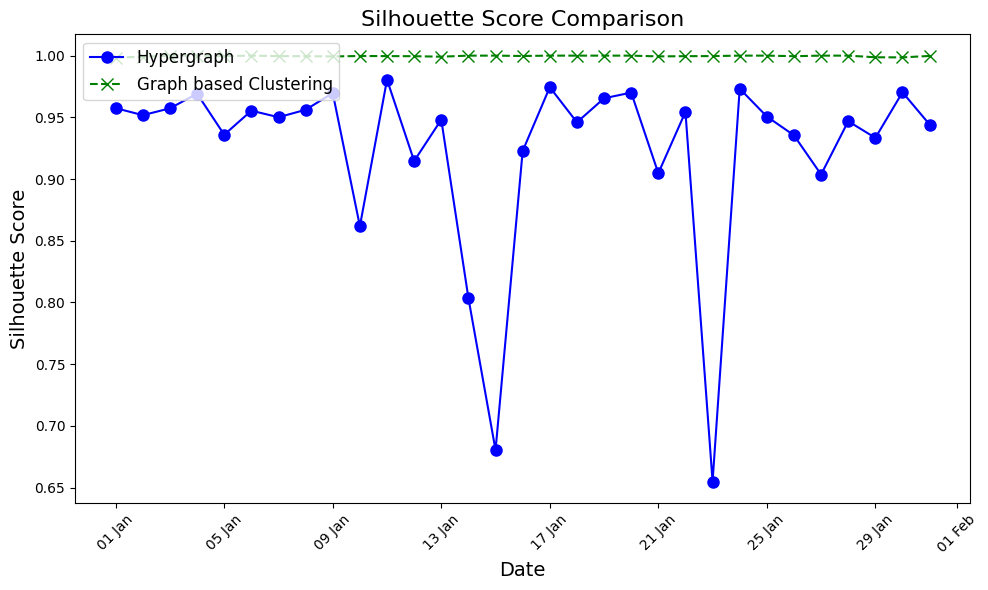

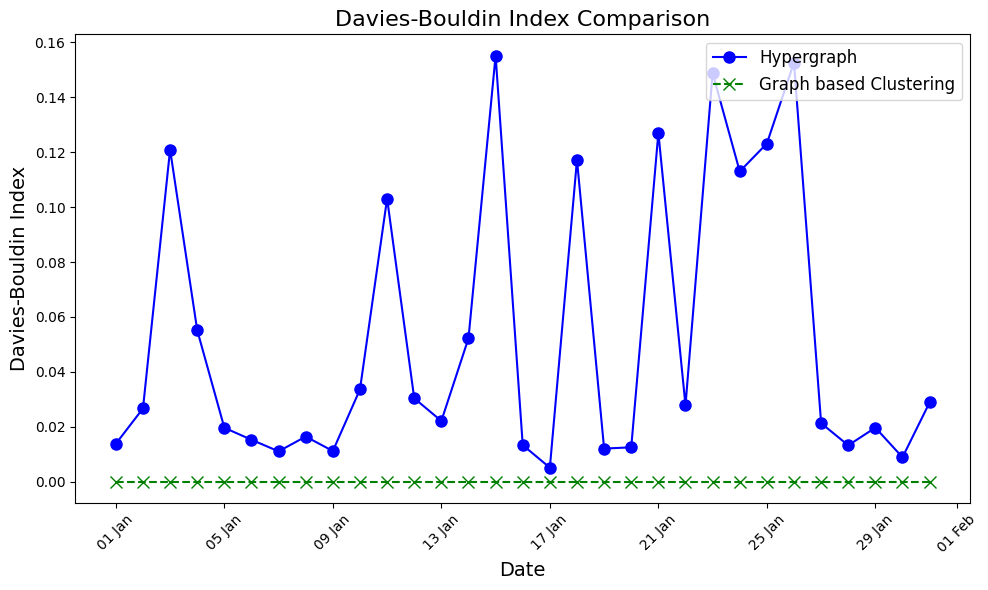

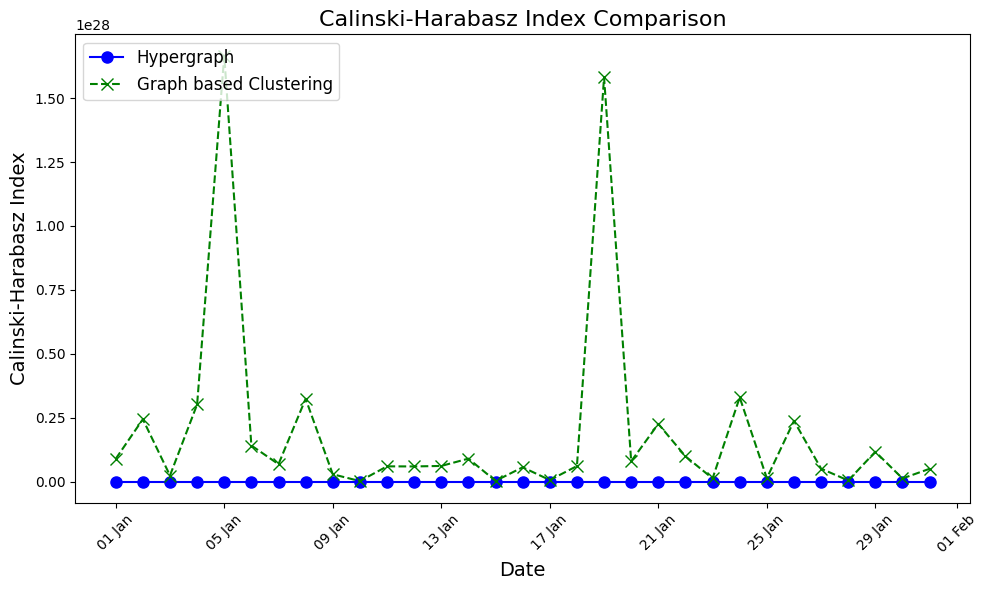

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Load the CSV files for HG and standard metrics
hg_metrics_df = pd.read_csv('clustering_metrics_HG.csv')
standard_metrics_df = pd.read_csv('clustering_metrics.csv')

# Set the file column as the index for easier comparison
hg_metrics_df.set_index('file', inplace=True)
standard_metrics_df.set_index('file', inplace=True)

# Convert the index (file names) to datetime format
hg_metrics_df.index = pd.to_datetime(hg_metrics_df.index, format='%Y-%m-%d.csv')
standard_metrics_df.index = pd.to_datetime(standard_metrics_df.index, format='%Y-%m-%d.csv')

# Define plot style for better aesthetics
plt.style.use('seaborn-v0_8-muted')

# Plot for Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(hg_metrics_df.index, hg_metrics_df['silhouette_score'], label='Hypergraph', marker='o', linestyle='-', color='blue', markersize=8)
plt.plot(standard_metrics_df.index, standard_metrics_df['Silhouette Score'], label='Graph based Clustering', marker='x', linestyle='--', color='green', markersize=8)
plt.title('Silhouette Score Comparison', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%d %b'))  # Format X-axis to show date like '1st Jan'
plt.tight_layout()
plt.show()

# Plot for Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(hg_metrics_df.index, hg_metrics_df['davies_bouldin_index'], label='Hypergraph', marker='o', linestyle='-', color='blue', markersize=8)
plt.plot(standard_metrics_df.index, standard_metrics_df['Davies-Bouldin Index'], label='Graph based Clustering', marker='x', linestyle='--', color='green', markersize=8)
plt.title('Davies-Bouldin Index Comparison', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Davies-Bouldin Index', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%d %b'))  # Format X-axis to show date like '1st Jan'
plt.tight_layout()
plt.show()

# Plot for Calinski-Harabasz Index
plt.figure(figsize=(10, 6))
plt.plot(hg_metrics_df.index, hg_metrics_df['calinski_harabasz_index'], label='Hypergraph', marker='o', linestyle='-', color='blue', markersize=8)
plt.plot(standard_metrics_df.index, standard_metrics_df['Calinski-Harabasz Index'], label='Graph based Clustering', marker='x', linestyle='--', color='green', markersize=8)
plt.title('Calinski-Harabasz Index Comparison', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Calinski-Harabasz Index', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%d %b'))  # Format X-axis to show date like '1st Jan'
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("label_jan/2020-01-01.csv")

# Each row is one transaction
num_transactions = len(df)

print("Number of transactions on 2020-01-01:", num_transactions)


Number of transactions on 2020-01-01: 18904


In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("label_jan/2020-01-01.csv")

# Count unique (fromLabel, toLabel) pairs
unique_pairs = df[['fromLabel', 'toLabel']].drop_duplicates()

print("Number of unique (from → to) pairs:", len(unique_pairs))


Number of unique (from → to) pairs: 2773


In [3]:
import pandas as pd

# Load the file
df = pd.read_csv("label_jan/2020-01-01.csv")

# Combine all wallet labels from 'fromLabel' and 'toLabel'
all_wallets = pd.concat([df['fromLabel'], df['toLabel']])

# Get unique wallet addresses
unique_wallets = all_wallets.unique()

print("Number of unique wallets:", len(unique_wallets))


Number of unique wallets: 1907


In [4]:
import pandas as pd
import os

# Path to your folder
folder_path = "label_jan/"

# Initialize counter
total_transactions = 0

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        total_transactions += len(df)

print("Total number of transactions in folder:", total_transactions)


Total number of transactions in folder: 839356


In [6]:
import os
import pandas as pd
import re

# Folder containing your txt files
folder_path = 'clustering_Graph'  # Update with your actual folder path

# List to store cluster information
cluster_data = []

# Iterate through all text files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):  # Process only txt files
        file_path = os.path.join(folder_path, filename)
        
        with open(file_path, 'r') as file:
            content = file.readlines()
            
            # Extract cluster data using regex
            for line in content:
                match = re.match(r'Cluster (\d+): (\d+) nodes', line.strip())
                if match:
                    cluster_number = int(match.group(1))
                    cluster_size = int(match.group(2))
                    # Add file name, cluster number, and cluster size to the data list
                    cluster_data.append({'File Name': filename, 'Cluster Number': cluster_number, 'Cluster Size': cluster_size})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(cluster_data)

# Print the dataframe to check the output
print(df)

# Optionally, save the dataframe to a CSV file
df.to_csv('cluster_sizes_with_filename.csv', index=False)


                             File Name  Cluster Number  Cluster Size
0     2020-01-01.csv_cluster_sizes.txt               0          1683
1     2020-01-01.csv_cluster_sizes.txt               3             4
2     2020-01-01.csv_cluster_sizes.txt              10            11
3     2020-01-01.csv_cluster_sizes.txt               6            22
4     2020-01-01.csv_cluster_sizes.txt              13             2
...                                ...             ...           ...
2653  2020-01-31.csv_cluster_sizes.txt              35             2
2654  2020-01-31.csv_cluster_sizes.txt              59             2
2655  2020-01-31.csv_cluster_sizes.txt              19             4
2656  2020-01-31.csv_cluster_sizes.txt              36             2
2657  2020-01-31.csv_cluster_sizes.txt              25             2

[2658 rows x 3 columns]


In [7]:
import os
import pandas as pd
import re

# Folder containing your txt files
folder_path = 'clustering_Graph'  # Update with your actual folder path

# List to store cluster information
cluster_data = []

# Iterate through all text files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):  # Process only txt files
        file_path = os.path.join(folder_path, filename)
        
        with open(file_path, 'r') as file:
            content = file.readlines()
            
            # Initialize cluster counter for each file
            cluster_count = 0
            
            # Extract cluster data using regex
            for line in content:
                match = re.match(r'Cluster (\d+): (\d+) nodes', line.strip())
                if match:
                    cluster_count += 1  # Increment the cluster count for each cluster found
                    
            # Add the file name and total cluster count to the data list
            cluster_data.append({'File Name': filename, 'Total Clusters': cluster_count})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(cluster_data)

# Print the dataframe to check the output
print(df)

# Optionally, save the dataframe to a CSV file
df.to_csv('total_clusters_per_day.csv', index=False)


                           File Name  Total Clusters
0   2020-01-01.csv_cluster_sizes.txt              75
1   2020-01-02.csv_cluster_sizes.txt              88
2   2020-01-03.csv_cluster_sizes.txt              78
3   2020-01-04.csv_cluster_sizes.txt              74
4   2020-01-05.csv_cluster_sizes.txt              78
5   2020-01-06.csv_cluster_sizes.txt             107
6   2020-01-07.csv_cluster_sizes.txt              92
7   2020-01-08.csv_cluster_sizes.txt              81
8   2020-01-09.csv_cluster_sizes.txt              85
9   2020-01-10.csv_cluster_sizes.txt              84
10  2020-01-11.csv_cluster_sizes.txt              84
11  2020-01-12.csv_cluster_sizes.txt              93
12  2020-01-13.csv_cluster_sizes.txt              86
13  2020-01-14.csv_cluster_sizes.txt              85
14  2020-01-15.csv_cluster_sizes.txt              88
15  2020-01-16.csv_cluster_sizes.txt             100
16  2020-01-17.csv_cluster_sizes.txt              78
17  2020-01-18.csv_cluster_sizes.txt          

In [8]:
import os
import pandas as pd
import re

# Folder containing your txt files
folder_path = 'clustering_HG'  # Update with your actual folder path

# List to store cluster information
cluster_data = []

# Iterate through all text files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):  # Process only txt files
        file_path = os.path.join(folder_path, filename)
        
        with open(file_path, 'r') as file:
            content = file.readlines()
            
            # Extract the total number of clusters from the first line
            match_clusters = re.match(r'Number of clusters: (\d+)', content[1].strip())
            if match_clusters:
                total_clusters = int(match_clusters.group(1))
                
                # Add the file name and total cluster count to the data list
                cluster_data.append({'File Name': filename, 'Total Clusters': total_clusters})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(cluster_data)

# Print the dataframe to check the output
print(df)

# Optionally, save the dataframe to a CSV file
df.to_csv('total_clusters_per_day_HG.csv', index=False)



                          File Name  Total Clusters
0   2020-01-01.csv_cluster_info.txt              17
1   2020-01-02.csv_cluster_info.txt              10
2   2020-01-03.csv_cluster_info.txt              15
3   2020-01-04.csv_cluster_info.txt              18
4   2020-01-05.csv_cluster_info.txt              20
5   2020-01-06.csv_cluster_info.txt              19
6   2020-01-07.csv_cluster_info.txt              23
7   2020-01-08.csv_cluster_info.txt              13
8   2020-01-09.csv_cluster_info.txt              15
9   2020-01-10.csv_cluster_info.txt              15
10  2020-01-11.csv_cluster_info.txt              16
11  2020-01-12.csv_cluster_info.txt              21
12  2020-01-13.csv_cluster_info.txt              17
13  2020-01-14.csv_cluster_info.txt              15
14  2020-01-15.csv_cluster_info.txt              21
15  2020-01-16.csv_cluster_info.txt              15
16  2020-01-17.csv_cluster_info.txt              20
17  2020-01-18.csv_cluster_info.txt              18
18  2020-01-

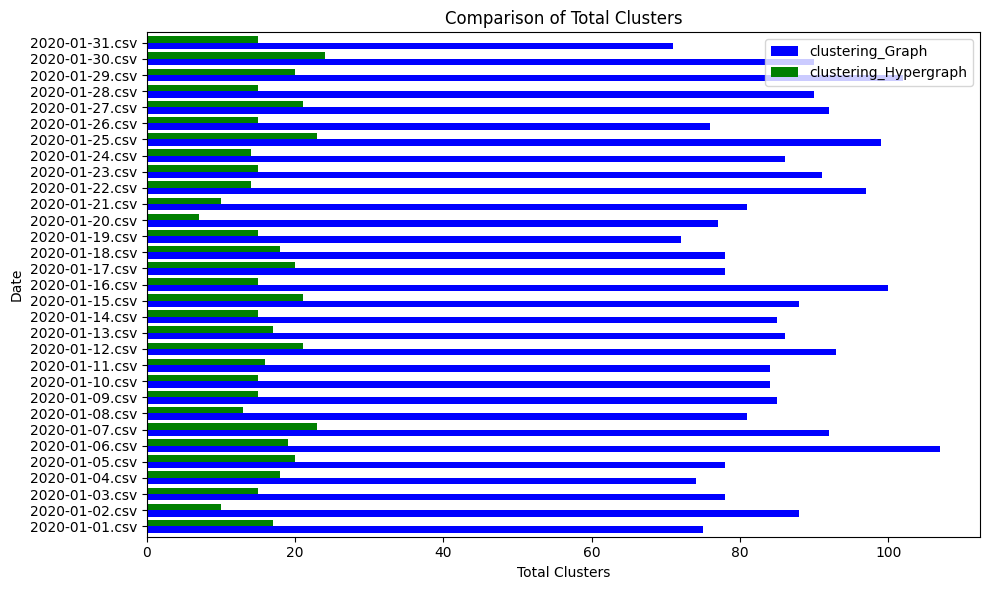

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved CSV files for both datasets
df_graph = pd.read_csv('total_clusters_per_day.csv')  # Assuming this is saved from the first part
df_hg = pd.read_csv('total_clusters_per_day_HG.csv')  # Assuming this is saved from the second part

# Add a 'Folder' column to differentiate between the two datasets
df_graph['Folder'] = 'clustering_Graph'
df_hg['Folder'] = 'clustering_HG'

# Combine both dataframes into one for comparison
df_combined = pd.concat([df_graph, df_hg], ignore_index=True)

# Assuming 'File Name' contains the date in a recognizable format, extract the date
df_combined['Date'] = df_combined['File Name'].apply(lambda x: x.split('_')[0])

# Group by 'Date' and 'Folder', then calculate the total clusters per day
df_day_wise = df_combined.groupby(['Date', 'Folder'])['Total Clusters'].sum().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot with 'Date' on the y-axis and total clusters on the x-axis
df_day_wise.plot(kind='barh', ax=ax, color=['blue', 'green'], width=0.8)

# Adding labels and title
ax.set_xlabel('Total Clusters')
ax.set_ylabel('Date')
ax.set_title('Comparison of Total Clusters')
ax.legend(['clustering_Graph', 'clustering_Hypergraph'], loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# Optionally, save the plot to a file
# plt.savefig('cluster_comparison_day_by_day.png', bbox_inches='tight')


In [19]:
import pandas as pd
import re
from pathlib import Path

folder_path = Path("clustering_HG")
data = []

# Process each .txt file in the folder
for txt_file in folder_path.glob("*.txt"):
    with open(txt_file, "r") as file:
        content = file.read()
        
        # Extract the corresponding CSV file name
        file_match = re.search(r"File:\s*(.*\.csv)", content)
        file_name = file_match.group(1) if file_match else txt_file.name

        # Find all cluster sizes
        cluster_sizes = [int(match.group(1)) for match in re.finditer(r"Cluster \d+:\s+(\d+)\s+nodes", content)]

        if cluster_sizes:
            max_cluster_size = max(cluster_sizes)
        else:
            max_cluster_size = 0  # fallback in case no clusters found

        data.append({
            "File Name": file_name,
            "Max Cluster Size": max_cluster_size
        })

# Create a DataFrame
df_max_clusters = pd.DataFrame(data)

# Display the result
print(df_max_clusters)

# Optionally save
# df_max_clusters.to_csv("max_cluster_sizes_HG.csv", index=False)


                   File Name  Max Cluster Size
0   label_jan\2020-01-01.csv              1765
1   label_jan\2020-01-02.csv              2309
2   label_jan\2020-01-03.csv              2404
3   label_jan\2020-01-04.csv              2211
4   label_jan\2020-01-05.csv              2389
5   label_jan\2020-01-06.csv              2688
6   label_jan\2020-01-07.csv              2451
7   label_jan\2020-01-08.csv              2207
8   label_jan\2020-01-09.csv              2977
9   label_jan\2020-01-10.csv              2334
10  label_jan\2020-01-11.csv              2438
11  label_jan\2020-01-12.csv              2081
12  label_jan\2020-01-13.csv              2263
13  label_jan\2020-01-14.csv              1638
14  label_jan\2020-01-15.csv              2286
15  label_jan\2020-01-16.csv              2826
16  label_jan\2020-01-17.csv              2851
17  label_jan\2020-01-18.csv              2102
18  label_jan\2020-01-19.csv              2046
19  label_jan\2020-01-20.csv              2306
20  label_jan

In [20]:
import pandas as pd
import re
from pathlib import Path

folder_path = Path("clustering_Graph")
data = []

# Process each .txt file in the folder
for txt_file in folder_path.glob("*.txt"):
    with open(txt_file, "r") as file:
        content = file.read()

        # Extract the corresponding CSV file name
        file_match = re.search(r"Cluster Sizes for\s*(.*\.csv)", content)
        file_name = file_match.group(1) if file_match else txt_file.name

        # Find all cluster sizes
        cluster_sizes = [int(match.group(1)) for match in re.finditer(r"Cluster \d+:\s+(\d+)\s+nodes", content)]

        if cluster_sizes:
            max_cluster_size = max(cluster_sizes)
        else:
            max_cluster_size = 0

        data.append({
            "File Name": file_name,
            "Max Cluster Size": max_cluster_size
        })

# Create a DataFrame
df_max_clusters_graph = pd.DataFrame(data)

# Display the result
print(df_max_clusters_graph)

# Optionally save
# df_max_clusters_graph.to_csv("max_cluster_sizes_Graph.csv", index=False)


         File Name  Max Cluster Size
0   2020-01-01.csv              1683
1   2020-01-02.csv              2076
2   2020-01-03.csv              2219
3   2020-01-04.csv              2090
4   2020-01-05.csv              2252
5   2020-01-06.csv              2437
6   2020-01-07.csv              2289
7   2020-01-08.csv              1961
8   2020-01-09.csv              2719
9   2020-01-10.csv              3070
10  2020-01-11.csv              2241
11  2020-01-12.csv              1833
12  2020-01-13.csv              2026
13  2020-01-14.csv              2744
14  2020-01-15.csv              3093
15  2020-01-16.csv              3072
16  2020-01-17.csv              2964
17  2020-01-18.csv              1888
18  2020-01-19.csv              1869
19  2020-01-20.csv              2112
20  2020-01-21.csv              2971
21  2020-01-22.csv              1963
22  2020-01-23.csv              2387
23  2020-01-24.csv              2794
24  2020-01-25.csv              1907
25  2020-01-26.csv              1871
2

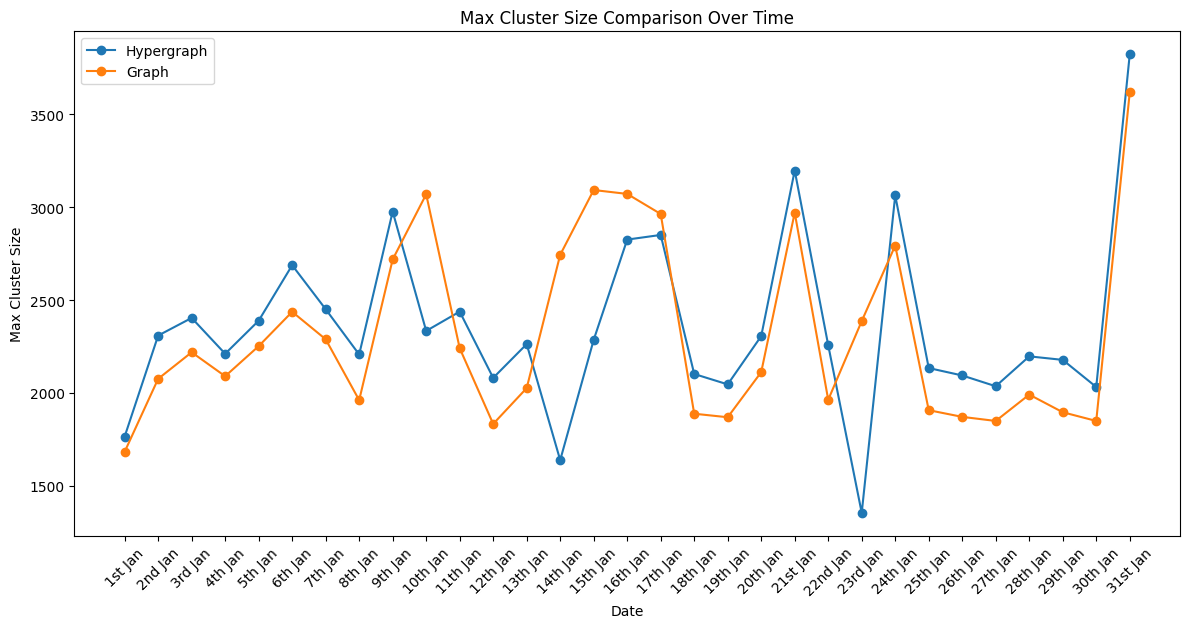

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def format_date_ordinal(date_obj):
    day = date_obj.day
    suffix = 'th' if 11 <= day <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get(day % 10, 'th')
    return f"{day}{suffix} {date_obj.strftime('%b')}"

df_max_clusters["Type"] = "Hypergraph"
df_max_clusters_graph["Type"] = "Graph"
df_combined = pd.concat([df_max_clusters, df_max_clusters_graph], ignore_index=True)
df_combined["Date"] = pd.to_datetime(df_combined["File Name"].str.extract(r"(\d{4}-\d{2}-\d{2})")[0])
df_combined = df_combined.sort_values("Date")
df_combined["Formatted Date"] = df_combined["Date"].apply(format_date_ordinal)

plt.figure(figsize=(12, 6))
for t in df_combined["Type"].unique():
    subset = df_combined[df_combined["Type"] == t]
    plt.plot(subset["Formatted Date"], subset["Max Cluster Size"], label=t, marker='o')

plt.title("Max Cluster Size Comparison Over Time")
plt.xlabel("Date")
plt.ylabel("Max Cluster Size")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


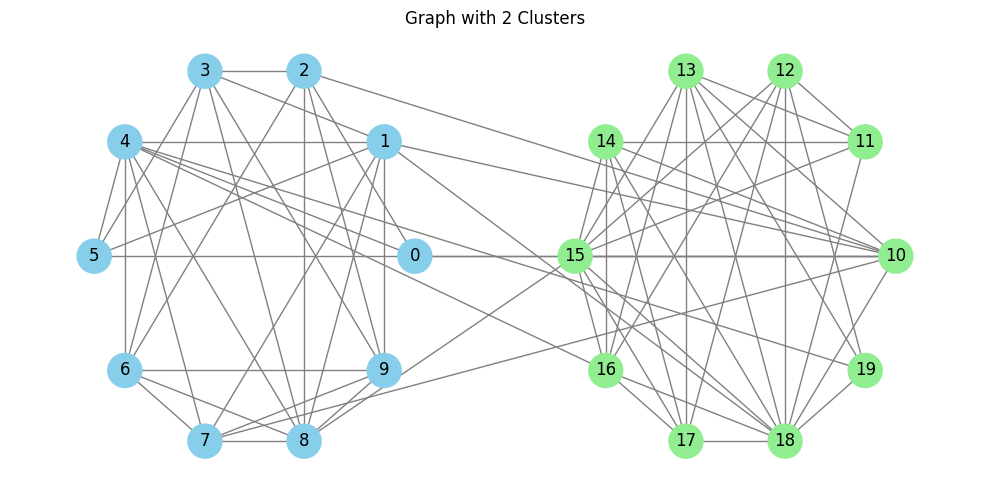

C:\Users\anand\AppData\Local\Temp\ipykernel_24084\1517133665.py:44: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


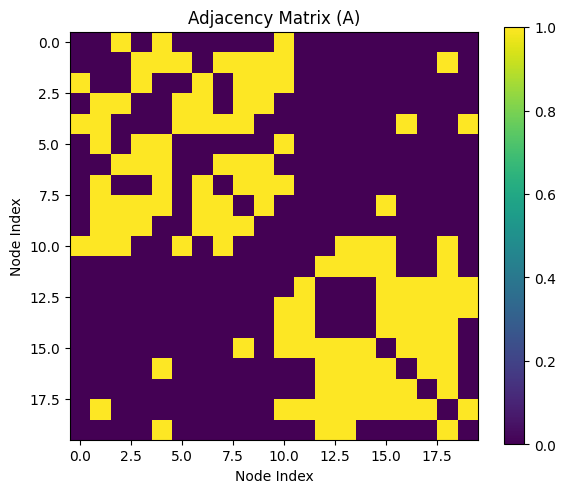

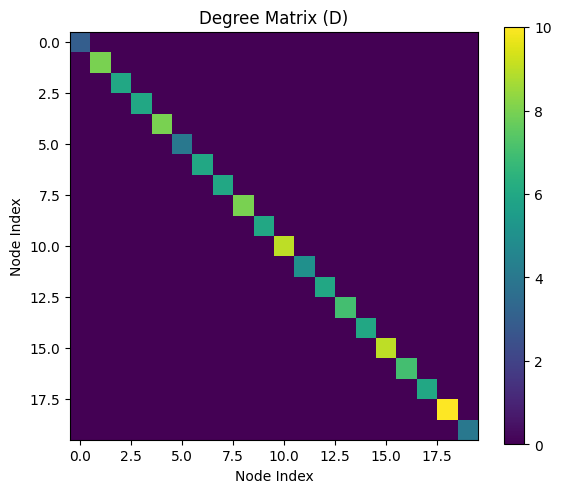

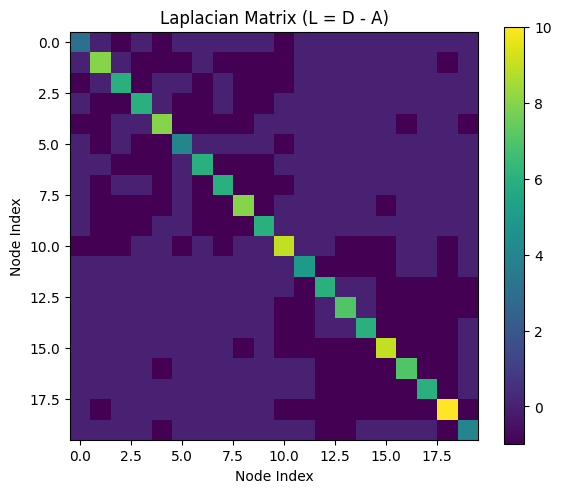

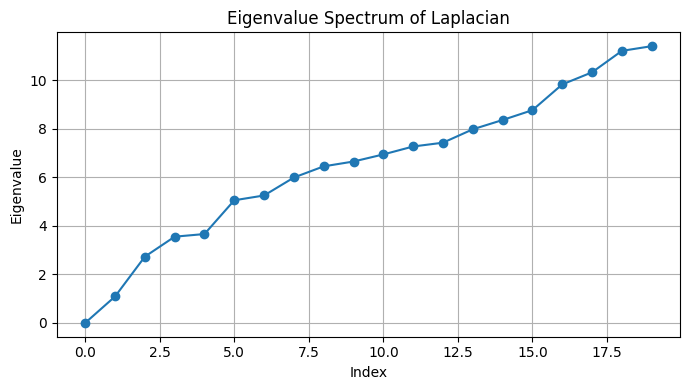

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Graph Creation
G = nx.Graph()
cluster1 = list(range(10))
cluster2 = list(range(10, 20))
G.add_nodes_from(cluster1 + cluster2)

for i in cluster1:
    for j in cluster1:
        if i < j and np.random.rand() < 0.6:
            G.add_edge(i, j)

for i in cluster2:
    for j in cluster2:
        if i < j and np.random.rand() < 0.6:
            G.add_edge(i, j)

for _ in range(10):
    G.add_edge(np.random.choice(cluster1), np.random.choice(cluster2))

# Layouts
pos_cluster1 = nx.circular_layout(cluster1)
pos_cluster2 = nx.circular_layout(cluster2)
for key in pos_cluster2:
    pos_cluster2[key][0] += 3
pos = {**pos_cluster1, **pos_cluster2}

# Step 2: Draw Graph
plt.figure(figsize=(10, 5))
nx.draw_networkx(
    G, pos, with_labels=True, node_size=600,
    node_color=['skyblue' if n in cluster1 else 'lightgreen' for n in G.nodes()],
    edge_color='gray'
)
plt.title("Graph with 2 Clusters")
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 3: Compute Matrices
A = nx.adjacency_matrix(G).todense()
D = np.diag([val for (node, val) in G.degree()])
L = D - A
eigenvalues = np.linalg.eigvalsh(L)

# Step 4: Plot Matrices as Images

def show_matrix(matrix, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.tight_layout()
    plt.show()

show_matrix(A, "Adjacency Matrix (A)")
show_matrix(D, "Degree Matrix (D)")
show_matrix(L, "Laplacian Matrix (L = D - A)")

# Step 5: Plot Eigenvalue Spectrum
plt.figure(figsize=(7, 4))
plt.plot(sorted(eigenvalues), marker='o', linestyle='-')
plt.title("Eigenvalue Spectrum of Laplacian")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()


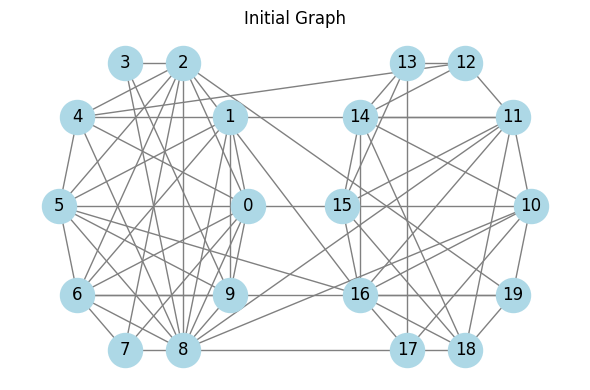

C:\Users\anand\AppData\Local\Temp\ipykernel_24084\571732513.py:48: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


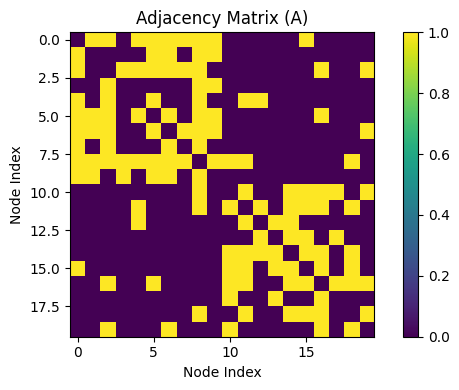

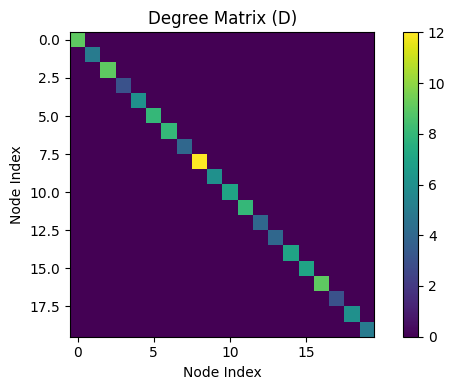

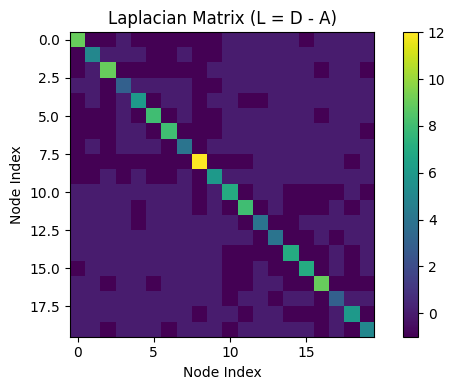

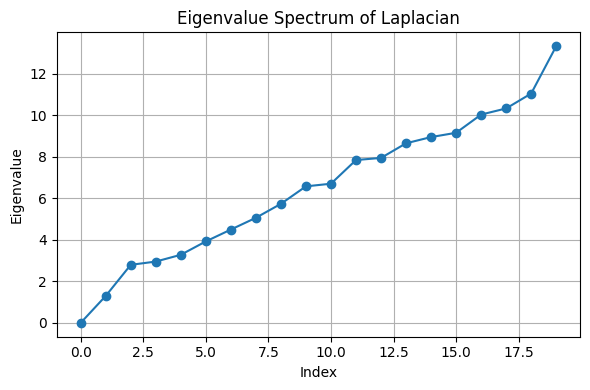

c:\Users\anand\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


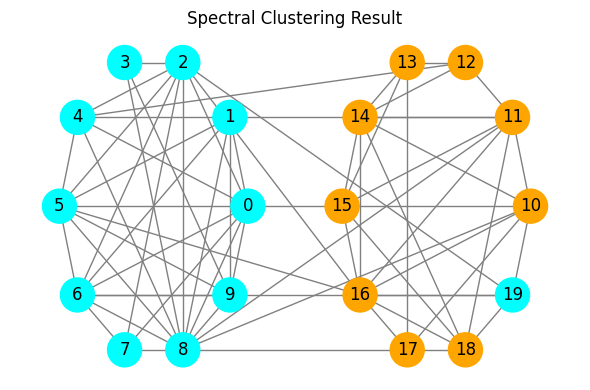

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Create Graph with Two Clusters
G = nx.Graph()
cluster1 = list(range(10))
cluster2 = list(range(10, 20))
G.add_nodes_from(cluster1 + cluster2)

# Intra-cluster edges
for i in cluster1:
    for j in cluster1:
        if i < j and np.random.rand() < 0.6:
            G.add_edge(i, j)

for i in cluster2:
    for j in cluster2:
        if i < j and np.random.rand() < 0.6:
            G.add_edge(i, j)

# Inter-cluster edges
for _ in range(10):
    G.add_edge(np.random.choice(cluster1), np.random.choice(cluster2))

# Layouts
pos_cluster1 = nx.circular_layout(cluster1)
pos_cluster2 = nx.circular_layout(cluster2)
for key in pos_cluster2:
    pos_cluster2[key][0] += 3
pos = {**pos_cluster1, **pos_cluster2}

# Step 2: Draw Initial Graph with same color for all nodes (Smaller Graph)
plt.figure(figsize=(6, 4))  # Smaller figure size
nx.draw_networkx(
    G, pos, with_labels=True, node_size=600,
    node_color='lightblue',  # Change this line to make all nodes the same color
    edge_color='gray'
)
plt.title("Initial Graph")
plt.axis('off')
plt.tight_layout()
plt.show()


# Step 3: Adjacency, Degree, Laplacian
A = nx.adjacency_matrix(G).todense()
D = np.diag([val for (node, val) in G.degree()])
L = D - A
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Step 4: Show Matrices (Smaller Graphs)
def show_matrix(matrix, title):
    plt.figure(figsize=(6, 4))  # Smaller figure size
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.tight_layout()
    plt.show()

show_matrix(A, "Adjacency Matrix (A)")
show_matrix(D, "Degree Matrix (D)")
show_matrix(L, "Laplacian Matrix (L = D - A)")

# Step 5: Eigenvalue Spectrum
plt.figure(figsize=(6, 4))  # Smaller figure size
plt.plot(sorted(eigenvalues), marker='o', linestyle='-')
plt.title("Eigenvalue Spectrum of Laplacian")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Spectral Clustering (KMeans on bottom 2 non-zero eigenvectors)
X = eigenvectors[:, 1:3]  # Skip the first (0) eigenvector for connected graph
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
labels = kmeans.fit_predict(X)

# Step 7: Visualize clustered graph (Smaller Graph)
colors = ['orange' if label == 0 else 'cyan' for label in labels]
plt.figure(figsize=(6, 4))  # Smaller figure size
nx.draw_networkx(
    G, pos, with_labels=True, node_size=600,
    node_color=colors,
    edge_color='gray'
)
plt.title("Spectral Clustering Result")
plt.axis('off')
plt.tight_layout()
plt.show()


c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
c:\Users\anand\anaconda3\lib\site-packages\hypernetx

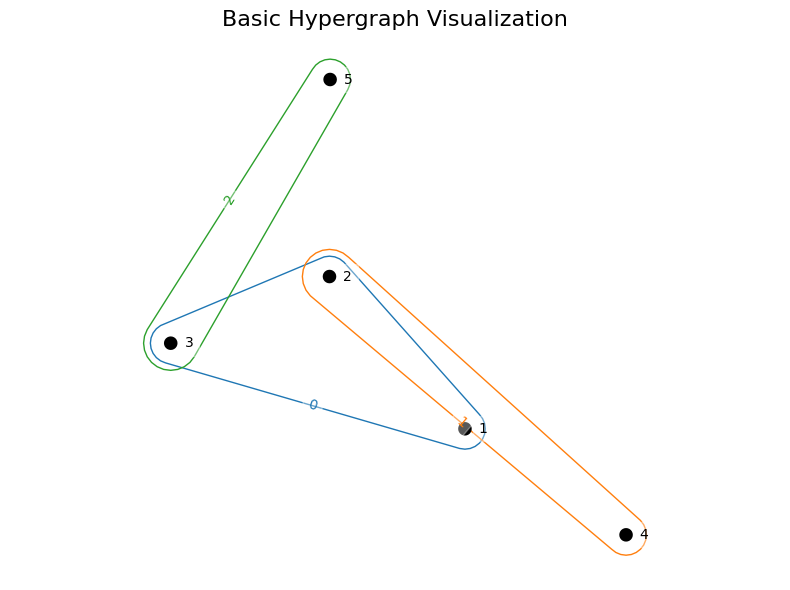

In [36]:
import hypernetx as hnx
import matplotlib.pyplot as plt

# Step 1: Define a Simple Hypergraph
# Define vertices
vertices = [1, 2, 3, 4, 5]

# Define hyperedges, where each hyperedge is a set of vertices
hyperedges = {
    0: [1, 2, 3],  # Hyperedge 0 connects vertices 1, 2, and 3
    1: [2, 4],     # Hyperedge 1 connects vertices 2 and 4
    2: [3, 5],     # Hyperedge 2 connects vertices 3 and 5
}

# Step 2: Create the Hypergraph
H = hnx.Hypergraph(hyperedges)

# Step 3: Visualize the Hypergraph
plt.figure(figsize=(8, 6))
hnx.draw(
    H
)

# Set the title
plt.title("Basic Hypergraph Visualization", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
c:\Users\anand\anaconda3\lib\site-packages\hypernetx

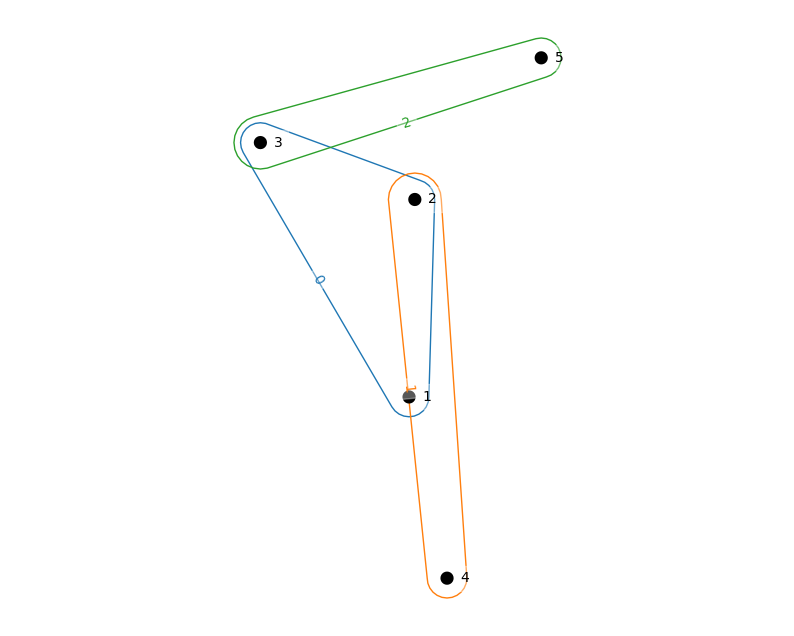

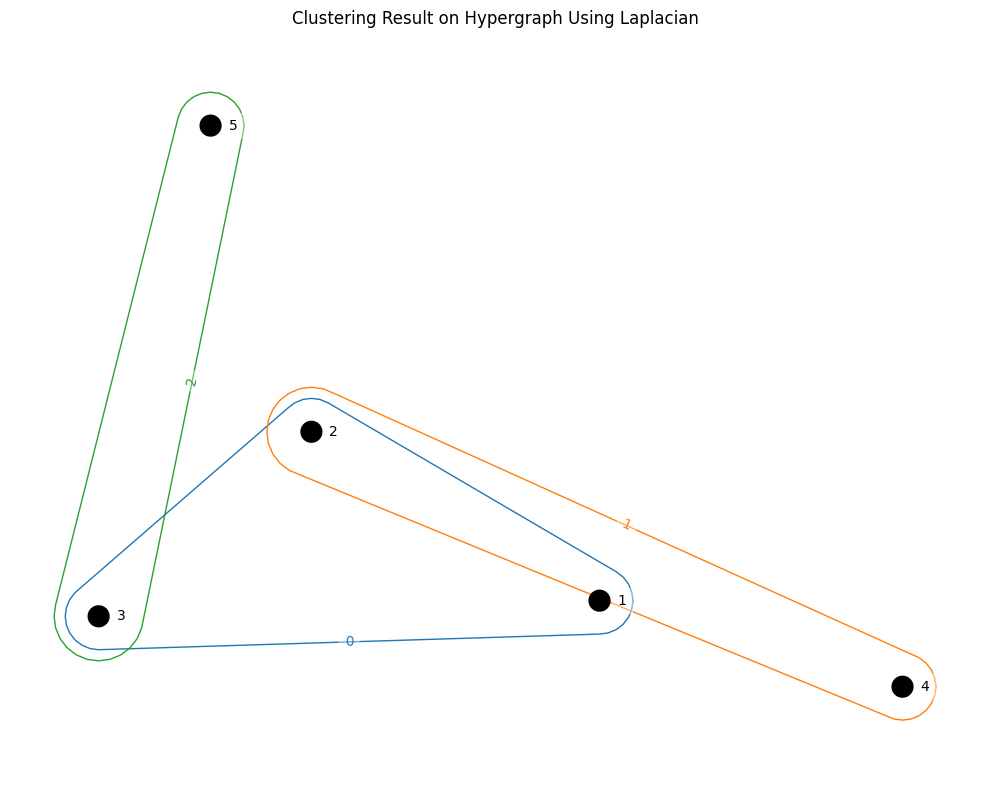

Eigenvalues of the Laplacian Matrix:
[0.31530526 0.38196601 1.37042139 2.31427335 2.61803399]


In [40]:
import numpy as np
import hypernetx as hnx
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Define the Hypergraph
# Define vertices
vertices = [1, 2, 3, 4, 5]

# Define hyperedges, where each hyperedge is a set of vertices
hyperedges = {
    0: [1, 2, 3],  # Hyperedge 0 connects vertices 1, 2, and 3
    1: [2, 4],     # Hyperedge 1 connects vertices 2 and 4
    2: [3, 5],     # Hyperedge 2 connects vertices 3 and 5
}

# Create the Hypergraph
H = hnx.Hypergraph(hyperedges)

# Step 2: Get the Incidence Matrix (H), Degree Matrix for Vertices (Dv) and Degree Matrix for Edges (De)
H_matrix = H.incidence_matrix().toarray()  # Incidence matrix H (convert to numpy array)
Dv = np.diag([len(H.neighbors(v)) for v in vertices])  # Degree matrix for vertices Dv
De = np.diag([len(edge) for edge in hyperedges.values()])  # Degree matrix for edges De

# Step 3: Compute the Hypergraph Laplacian L = Dv - H W De^{-1} H^T
# Set the weight matrix W (for simplicity, we'll set it to identity, i.e., unweighted edges)
W = np.eye(len(hyperedges))  # Weight matrix for edges (identity matrix for simplicity)

# Compute the Laplacian matrix L
L = Dv - np.dot(np.dot(H_matrix, np.linalg.inv(De)), H_matrix.T)

# Step 4: Eigenvalue Decomposition of the Laplacian Matrix
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Step 5: Use the second smallest eigenvector (Fiedler Vector) for clustering
# Select the second smallest eigenvector
second_smallest_eigenvector = eigenvectors[:, 1]

# Step 6: Perform KMeans clustering using the second smallest eigenvector
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(second_smallest_eigenvector.reshape(-1, 1))

# Step 7: Visualize the Results
# Visualizing the Hypergraph
plt.figure(figsize=(10, 8))
hnx.draw(H)

# Color nodes based on the clustering result
node_colors = ['orange' if label == 0 else 'cyan' for label in labels]

# Visualize the clustered nodes
plt.figure(figsize=(10, 8))

hnx.draw(H)

plt.title("Clustering Result on Hypergraph Using Laplacian")
plt.tight_layout()
plt.show()

# Displaying the eigenvalues for reference
print("Eigenvalues of the Laplacian Matrix:")
print(eigenvalues)


c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


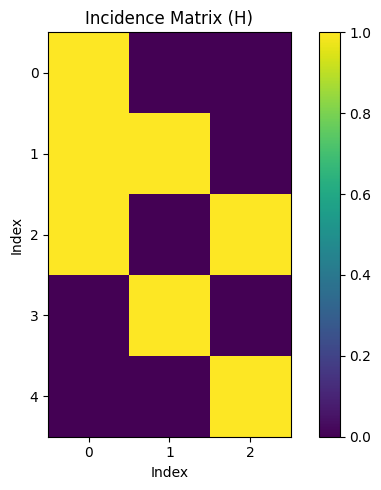

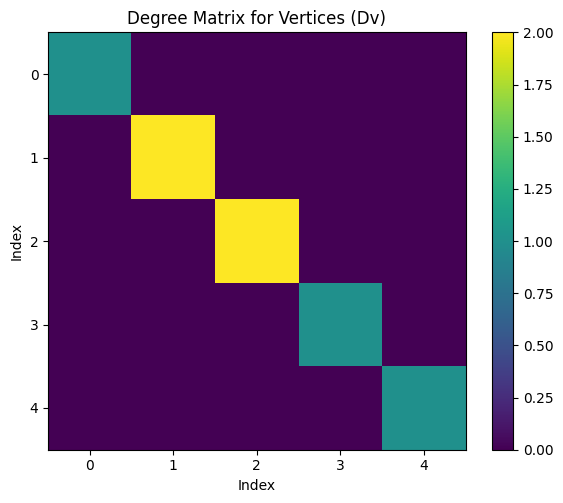

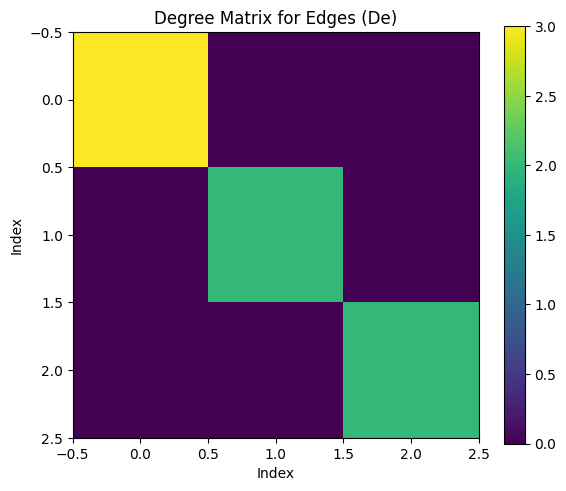

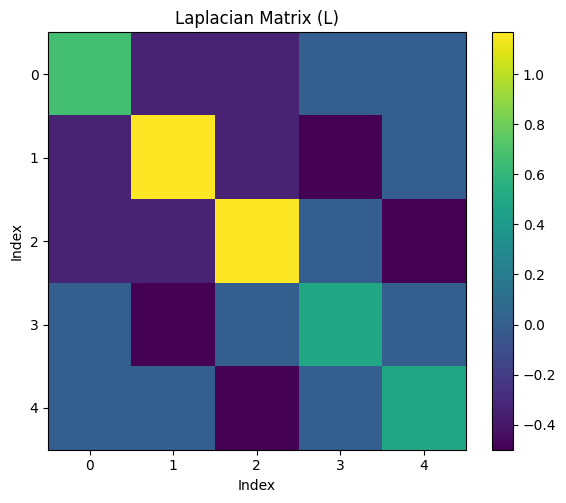

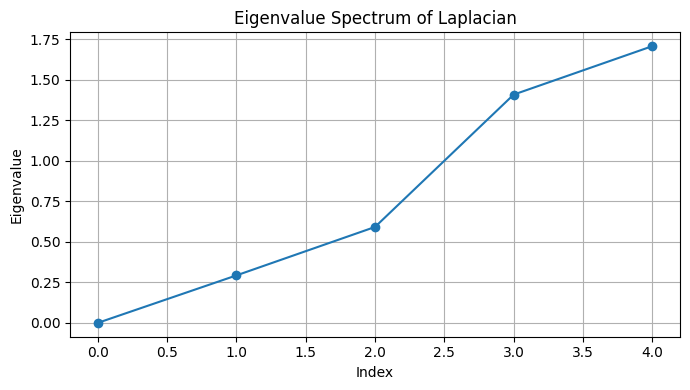


Incidence Matrix (H):
[[1 0 0]
 [1 1 0]
 [1 0 1]
 [0 1 0]
 [0 0 1]]

Degree Matrix for Vertices (Dv):
[[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Degree Matrix for Edges (De):
[[3 0 0]
 [0 2 0]
 [0 0 2]]

Laplacian Matrix (L):
[[ 0.66666667 -0.33333333 -0.33333333  0.          0.        ]
 [-0.33333333  1.16666667 -0.33333333 -0.5         0.        ]
 [-0.33333333 -0.33333333  1.16666667  0.         -0.5       ]
 [ 0.         -0.5         0.          0.5         0.        ]
 [ 0.          0.         -0.5         0.          0.5       ]]


In [54]:
import numpy as np
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Define the Hypergraph
vertices = [1, 2, 3, 4, 5]
hyperedges = {
    0: [1, 2, 3],  # Hyperedge 0 connects vertices 1, 2, and 3
    1: [2, 4],     # Hyperedge 1 connects vertices 2 and 4
    2: [3, 5],     # Hyperedge 2 connects vertices 3 and 5
}
H = hnx.Hypergraph(hyperedges)

# Step 2: Get Matrices
H_matrix = H.incidence_matrix().toarray()  # Incidence matrix H

# Degree matrix for vertices Dv: Number of hyperedges each vertex is part of
Dv = np.diag([sum(1 for edge in hyperedges.values() if v in edge) for v in vertices])  # Degree matrix for vertices Dv

# Degree matrix for edges De: Number of vertices each hyperedge is connected to
De = np.diag([len(edge) for edge in hyperedges.values()])  # Degree matrix for edges De

# Weight matrix for edges (identity matrix) W
W = np.eye(len(hyperedges))  # Weight matrix for edges (identity matrix)

# Laplacian Matrix L
L = Dv - np.dot(np.dot(H_matrix, np.linalg.inv(De)), H_matrix.T)

# Step 3: Eigen Decomposition for Eigenvalue Spectrum
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Step 4: Display All Matrices as Images
def show_matrix_as_image(matrix, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')  # Using 'viridis' color map for better visualization
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Index")
    plt.tight_layout()
    plt.show()

# Show all matrices as images
show_matrix_as_image(H_matrix, "Incidence Matrix (H)")
show_matrix_as_image(Dv, "Degree Matrix for Vertices (Dv)")
show_matrix_as_image(De, "Degree Matrix for Edges (De)")
show_matrix_as_image(L, "Laplacian Matrix (L)")

# Step 5: Plot Eigenvalue Spectrum as Image
plt.figure(figsize=(7, 4))
plt.plot(sorted(eigenvalues), marker='o', linestyle='-')
plt.title("Eigenvalue Spectrum of Laplacian")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()

# Save it as an image
plt.savefig("eigenvalue_spectrum.png")

# Show the plot
plt.show()

# Print matrices for the presentation (you can include this in the notes)
print("\nIncidence Matrix (H):")
print(H_matrix)

print("\nDegree Matrix for Vertices (Dv):")
print(Dv)

print("\nDegree Matrix for Edges (De):")
print(De)

print("\nLaplacian Matrix (L):")
print(L)


c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
c:\Users\anand\anaconda3\lib\site-packages\hypernetx\classes\entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


Cluster 1: [1, 2]
Cluster 0: [3, 4, 5]


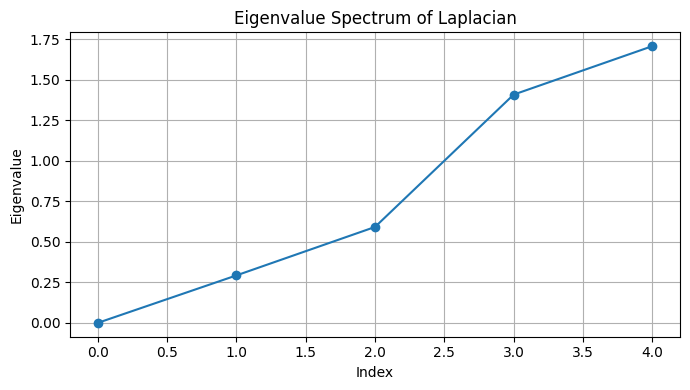


Incidence Matrix (H):
[[1 0 0]
 [1 1 0]
 [1 0 1]
 [0 1 0]
 [0 0 1]]

Degree Matrix for Vertices (Dv):
[[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Degree Matrix for Edges (De):
[[3 0 0]
 [0 2 0]
 [0 0 2]]

Laplacian Matrix (L):
[[ 0.66666667 -0.33333333 -0.33333333  0.          0.        ]
 [-0.33333333  1.16666667 -0.33333333 -0.5         0.        ]
 [-0.33333333 -0.33333333  1.16666667  0.         -0.5       ]
 [ 0.         -0.5         0.          0.5         0.        ]
 [ 0.          0.         -0.5         0.          0.5       ]]


In [64]:
import numpy as np
import hypernetx as hnx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict

# Step 1: Define the Hypergraph
vertices = [1, 2, 3, 4, 5]
hyperedges = {
    0: [1, 2, 3],  # Hyperedge 0 connects vertices 1, 2, and 3
    1: [2, 4],     # Hyperedge 1 connects vertices 2 and 4
    2: [3, 5],     # Hyperedge 2 connects vertices 3 and 5
}
H = hnx.Hypergraph(hyperedges)

# Step 2: Get Matrices
H_matrix = H.incidence_matrix().toarray()  # Incidence matrix H

# Degree matrix for vertices Dv: Number of hyperedges each vertex is part of
Dv = np.diag([sum(1 for edge in hyperedges.values() if v in edge) for v in vertices])  # Degree matrix for vertices Dv

# Degree matrix for edges De: Number of vertices each hyperedge is connected to
De = np.diag([len(edge) for edge in hyperedges.values()])  # Degree matrix for edges De

# Laplacian Matrix L
L = Dv - np.dot(np.dot(H_matrix, np.linalg.inv(De)), H_matrix.T)

# Step 3: Eigen Decomposition for Eigenvalue Spectrum
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Step 4: Use the 3rd Eigenvector for Clustering (index 2)
third_eigenvector = eigenvectors[:, 0]

# Step 5: Apply KMeans Clustering based on the 3rd Eigenvector with 3 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(third_eigenvector.reshape(-1, 1))  # Reshaping as it needs 2D data

# Step 6: Show Cluster Memberships
cluster_groups = defaultdict(list)
for node, label in zip(vertices, labels):
    cluster_groups[label].append(node)

# print("\nCluster memberships based on the 3rd Eigenvector:")
for cluster_id, group in cluster_groups.items():
    print(f"Cluster {cluster_id}: {group}")

# Step 7: Visualize the Eigenvalue Spectrum
plt.figure(figsize=(7, 4))
plt.plot(sorted(eigenvalues), marker='o', linestyle='-')
plt.title("Eigenvalue Spectrum of Laplacian")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Print matrices for presentation
print("\nIncidence Matrix (H):")
print(H_matrix)

print("\nDegree Matrix for Vertices (Dv):")
print(Dv)

print("\nDegree Matrix for Edges (De):")
print(De)

print("\nLaplacian Matrix (L):")
print(L)
